## SHAP Explainer :

### Main Code and Summary Plot :

In [1]:
# Verify SHAP version installed is latest one (0.39.0 in my case):
!pip show shap

# Install specific or latest version :
#!pip install shap==
#!pip install shap --upgrade

Name: shap
Version: 0.39.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: http://github.com/slundberg/shap
Author: Scott Lundberg
Author-email: slund1@cs.washington.edu
License: MIT
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: scipy, scikit-learn, cloudpickle, numpy, pandas, numba, slicer, tqdm
Required-by: interpret-community


EXPERIMENT: model=RF,outcome=mortality,T=48.0,dt=1.0
ICU stay splits: 6035 1278 1264
1031 / 8577

Time series shape, Static shape, Label shape, Class balance:
	 tr (6035, 48, 7323) (6035, 94) (6035, 1) 0.1251035625517813
	 va (1278, 48, 7323) (1278, 94) (1278, 1) 0.11267605633802817
	 te (1264, 48, 7323) (1264, 94) (1264, 1) 0.10443037974683544
Fused dimensions: torch.Size([48, 7417])
Printing information of Xtr , ytr , Xte and yte now............
(7313, 351598) (7313,) (1264, 351598) (1264,)
Printed .............................................
RF.............
JSON read done !!!!
351598
Initialising the SHAP Tree explainer for RF... 
(1264, 351598)
<class 'pandas.core.frame.DataFrame'>
Start explainer now......
<class 'shap.explainers._tree.Tree'>
<class 'list'>
Shap values were calculated......


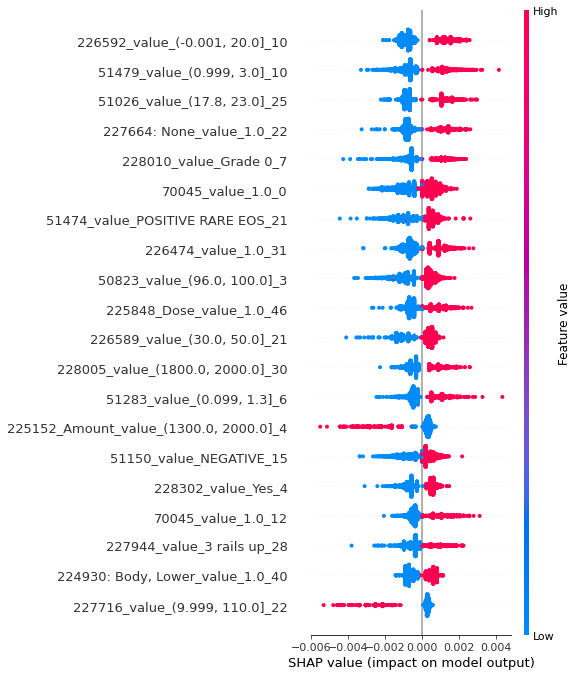

In [2]:
import sys, os, time, pickle, random
import pandas as pd
import numpy as np
import joblib

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import yaml

# Ashutosh added new imports for explaination:
import matplotlib.pyplot as plt
import plotly
import shap
#import lime
#import lime.lime_tabular
import json

with open('config.yaml') as f:
    config = yaml.safe_load(f)

data_path = config['data_path']
search_budget = config['train']['budget']


# Ashutosh added below :
os.environ['NUMEXPR_MAX_THREADS'] = '50'

#figure_path = '/mnt/disks/user/project/FIDDLE_experiments-master/mimic3_experiments/figures/' # Nibmlebox
figure_path = '/home/azureuser/cloudfiles/code/Users/ashutoshind2017/FIDDLE_experiments-master/mimic3_experiments/figures'  # Azure 

# Ashutosh changing the jobs from 50 to 22 :
n_jobs = 20
#n_jobs = -2

task = 'mortality'
model_type = 'RF'
model_name = model_type

T = 48.0
dt = 1.0

if model_type == 'CNN':
    assert False
elif model_type == 'RNN':
    assert False
elif model_type == 'LR':
    pass
elif model_type == 'RF':
    pass
else:
    assert False


print('EXPERIMENT:', 'model={},outcome={},T={},dt={}'.format(model_name, task, T, dt))

# Create checkpoint directories
import pathlib
pathlib.Path("./checkpoint/model={},outcome={},T={},dt={}/".format(model_name, task, T, dt)).mkdir(parents=True, exist_ok=True)

######
# Data
import lib.data as data
if task == 'mortality':
    tr_loader, va_loader, te_loader = data.get_benchmark_splits(fuse=True)
else:
    tr_loader, va_loader, te_loader = data.get_train_val_test(task, duration=T, timestep=dt, fuse=True)

# Reshape feature vectors
X_tr, s_tr, y_tr = tr_loader.dataset.X, tr_loader.dataset.s, tr_loader.dataset.y
X_va, s_va, y_va = va_loader.dataset.X, va_loader.dataset.s, va_loader.dataset.y
X_te, s_te, y_te = te_loader.dataset.X, te_loader.dataset.s, te_loader.dataset.y

X_tr.shape, s_tr.shape, y_tr.shape, X_va.shape, s_va.shape, y_va.shape, X_te.shape, s_te.shape, y_te.shape, 

# Concatenate tr+va to create large training set (used for cross-validation)
Xtr = np.concatenate([X_tr, X_va])
ytr = np.concatenate([y_tr, y_va]).ravel()
Str = np.concatenate([s_tr, s_va])

Xte = X_te
yte = y_te.ravel()
Ste = s_te

# Flatten time series features
Xtr = Xtr.reshape(Xtr.shape[0], -1)
Xte = Xte.reshape(Xte.shape[0], -1)

# Combine time-invariant and time series
Xtr = np.concatenate([Xtr, Str], axis=1)
Xte = np.concatenate([Xte, Ste], axis=1)

print("Printing information of Xtr , ytr , Xte and yte now............")
print(Xtr.shape, ytr.shape, Xte.shape, yte.shape)
print("Printed .............................................")

######
# Train model with CV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, feature_selection, utils
import scipy.stats
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

# Ashutosh adding the explaination module : 
if model_type == 'LR':
    #clf.fit(Xtr, ytr)
    print("LR..............")
else:
    #clf.fit(Xtr, ytr)
    print("RF.............")

    # Load json files :
    json_path = '/home/azureuser/cloudfiles/code/Users/ashutoshind2017/FIDDLE_experiments-master/mimic3_experiments/data/processed/output/'
    #json_path = '/mnt/disks/user/project/FIDDLE_experiments-master/mimic3_experiments/data/processed/output/' # Nimblebox

    f1 = open (json_path + 'S.feature_names.json', "r")
    J1 = json.loads(f1.read())
    #print(len(J1))
    #print(J1)
    f2 = open (json_path + 'X.feature_names.json', "r")
    J2 = json.loads(f2.read())
    #print(len(J2))
    
    print("JSON read done !!!!")
    feature_names = [feature+'_'+str(i) for feature in J2 for i in range(48)] + J1
    print(len(feature_names))
    
    df_Xtr = pd.DataFrame(Xtr, columns = feature_names)
    df_Xte = pd.DataFrame(Xte, columns = feature_names)
   
    # RFClassifier based on best params above from CV Results  :
    rf = RandomForestClassifier(criterion ='entropy', n_estimators=413, max_depth= None, max_features=89, min_samples_split = 4, min_samples_leaf = 1, random_state = 0,
                                class_weight='balanced' )
    
    # Fit :                       
    #rf.fit(Xtr, ytr)
    rf.fit(df_Xtr, ytr)
    
    
    ################################ Added SHAP explainataion ###############################
    print("Initialising the SHAP Tree explainer for RF... ")
    # Defining training sample :

    #sample_train_delta = df_Xtr.iloc[0:100, :]
    samples_train = df_Xtr
    
    #sample_test_delta = df_Xte.iloc[0:10,:]  # Working 
    samples_test = df_Xte
    
    #print(sample_train.shape)
    print(samples_test.shape)
    
    #print(type(sample_train))
    print(type(samples_test))
###############
    
    print("Start explainer now......")
    
    import shap
    #shap_values = shap.TreeExplainer(rf).shap_values(sample_train, approximate=True, check_additivity=False) # Working
    #shap_values = shap.TreeExplainer(rf).shap_values(samples_test, approximate=True, check_additivity=False)
    
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(samples_test, approximate=True, check_additivity=False)
   
    print(type(explainer))
    print(type(shap_values))

    print("Shap values were calculated......")
    
############## SHAP Summary Plots ############### :
    
    shap.initjs()
    f = plt.figure(figsize =(30,20))
    #shap.summary_plot(shap_values, samples_test ) # Working but not saved correctly (partially cut)
    shap.summary_plot(shap_values[1], samples_test, show=False)  
    #Save figures  :
    f.tight_layout()
    f.savefig(figure_path + 'Summary_Plot_SHAP_ipynb.png', dpi=600, bbox_inches='tight') # added bbox_inches='tight'

### SHAP Waterfall Plots :

In [3]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    
    '''
    A function for building a SHAP waterfall plot.
    
    SHAP waterfall plot is used to visualize the most important features in a descending order.
    
    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display
    
    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot
    
    '''
    
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.4 µs


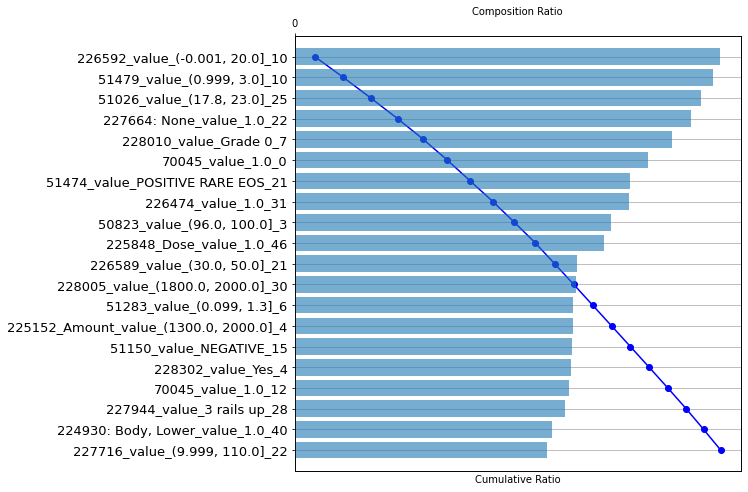

In [4]:
%time
# Shap waterfall plot
f = make_shap_waterfall_plot(shap_values[1], samples_test)

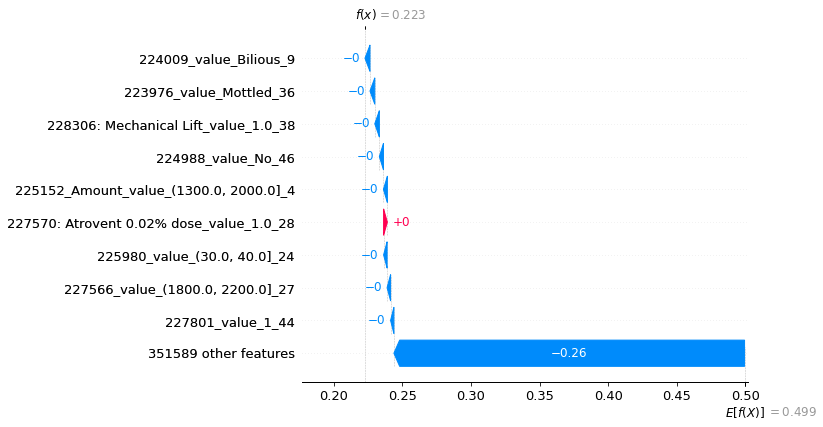

In [5]:
######## SHAP Waterfall Plots 2nd data point :
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][1],  feature_names = feature_names) ############ Should be 0 or 1 ?


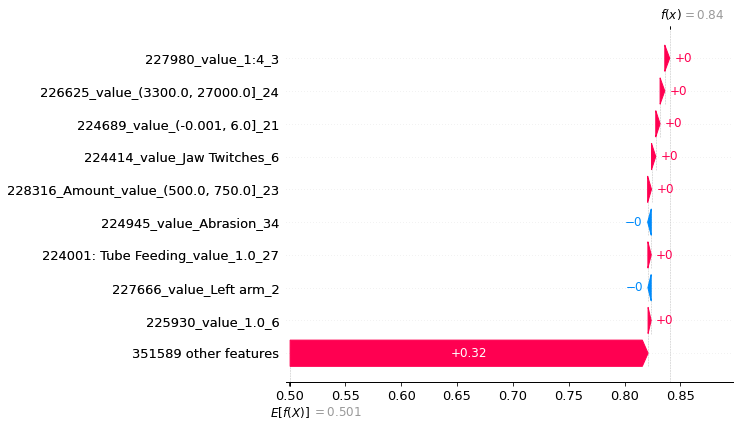

In [6]:
# Waterfall plot 1st data point :
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0],  feature_names = feature_names) ############ Should be 0 or 1 ?

### SHAP Dependence Plot :

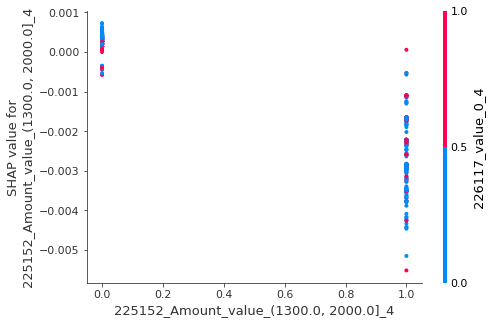

In [7]:
###### SHAP Dependence Plots:

# 225152_Amount_value_(1300.0, 2000.0]_4

f = shap.dependence_plot("225152_Amount_value_(1300.0, 2000.0]_4", shap_values[1], samples_test)

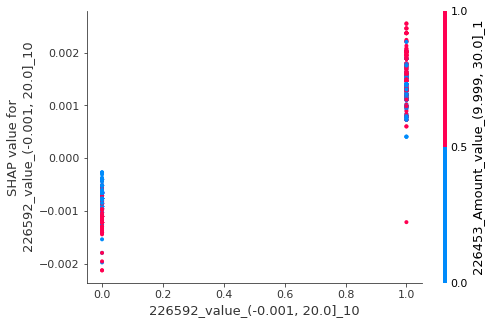

In [8]:
# 226592_value_(-0.001, 20.0]_10

f = shap.dependence_plot("226592_value_(-0.001, 20.0]_10", shap_values[1], samples_test)

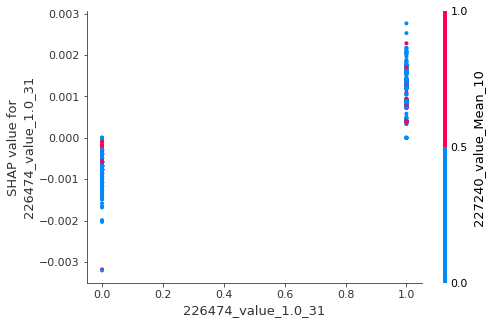

In [9]:
#  226474_value_1.0_31

f = shap.dependence_plot("226474_value_1.0_31", shap_values[1], samples_test)

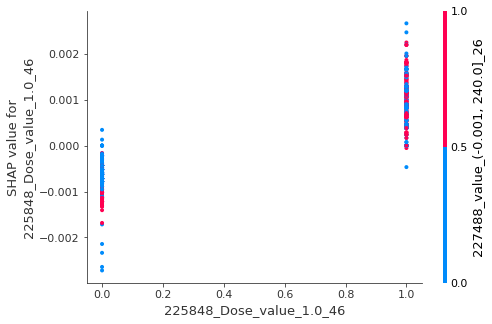

In [10]:
#225848_Dose_value_1.0_46

f = shap.dependence_plot("225848_Dose_value_1.0_46", shap_values[1], samples_test)

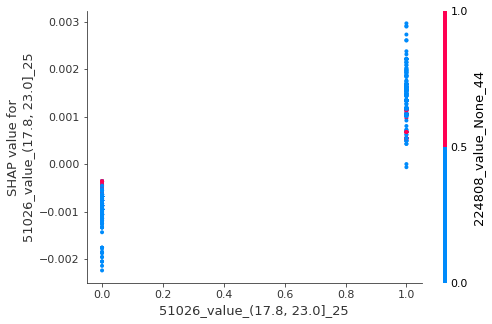

In [11]:
# 51026_value_(17.8, 23.0]_25

f = shap.dependence_plot("51026_value_(17.8, 23.0]_25", shap_values[1], samples_test)

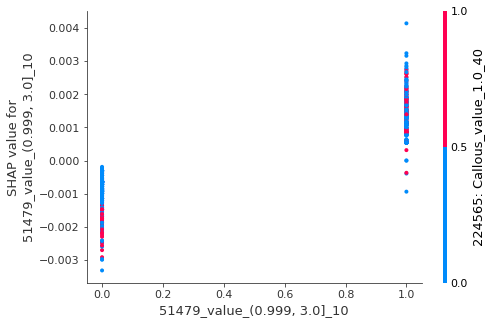

In [12]:
# 51479_value_(0.999, 3.0]_10

f = shap.dependence_plot("51479_value_(0.999, 3.0]_10", shap_values[1], samples_test)

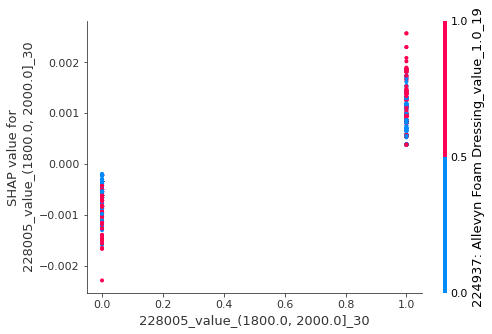

In [13]:
#228005_value_(1800.0, 2000.0]_30
    
# SHAP Dependence plots for different features :
f = shap.dependence_plot("228005_value_(1800.0, 2000.0]_30", shap_values[1], samples_test)


### SHAP Dependence Interaction Plots:

<Figure size 432x288 with 0 Axes>

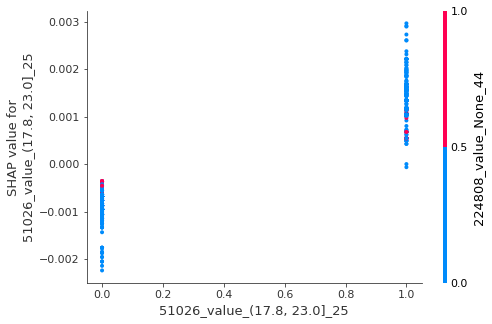

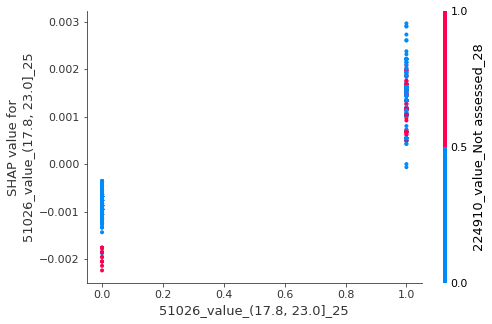

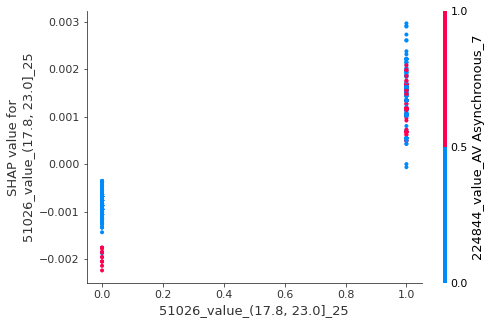

In [33]:
###### SHAP Dependence Interaction Plots :

# SHAP Interaction plots : 
# we can use shap.approximate_interactions to guess which features may interact with a feature : 
inds = shap.approximate_interactions("51026_value_(17.8, 23.0]_25", shap_values[1], samples_test)

# Make plots colored by each of the top three possible interacting features:
plt.figure()
for i in range(3):
    shap.dependence_plot("51026_value_(17.8, 23.0]_25", shap_values[1], samples_test, interaction_index=inds[i])

<Figure size 432x288 with 0 Axes>

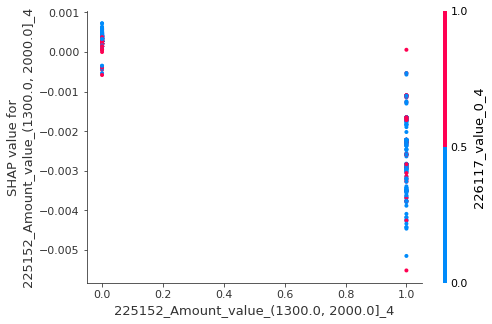

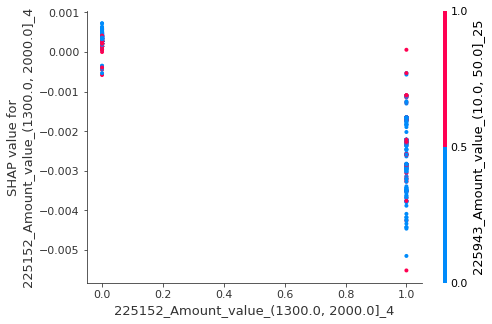

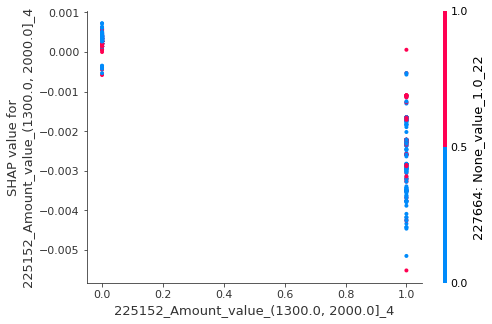

In [36]:
# 225152_Amount_value_(1300.0, 2000.0]_4

inds = shap.approximate_interactions("225152_Amount_value_(1300.0, 2000.0]_4", shap_values[1], samples_test)

# Make plots colored by each of the top three possible interacting features:
plt.figure()
for i in range(3):
    shap.dependence_plot("225152_Amount_value_(1300.0, 2000.0]_4", shap_values[1], samples_test, interaction_index=inds[i])

### SHAP Force Plot:

In [41]:
samples_test.loc[[7]]

,220045_mask_0,220045_mask_1,220045_mask_2,220045_mask_3,220045_mask_4,220045_mask_5,220045_mask_6,220045_mask_7,220045_mask_8,220045_mask_9,...,RELIGION_value_HINDU,RELIGION_value_JEHOVAH'S WITNESS,RELIGION_value_JEWISH,RELIGION_value_MUSLIM,RELIGION_value_NOT SPECIFIED,RELIGION_value_OTHER,RELIGION_value_PROTESTANT QUAKER,RELIGION_value_ROMANIAN EAST. ORTH,RELIGION_value_UNITARIAN-UNIVERSALIST,RELIGION_value_UNOBTAINABLE
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### SHAP Individual Force Plot : 

In [51]:
# 7th ICU Admission :

# Recreate the explainer :
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
#choosen_instance = sample_train_delta.loc[[7]]
choosen_instance = samples_test.loc[[7]]

shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
shap.initjs()

#plt.figure()
f = shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)
shap.save_html(figure_path + 'SHAP_Individual_Force_Plot_7thAdmission.htm', f)



In [49]:
# 50th ICU Admission :

# Calculate Shap values
#choosen_instance = sample_train_delta.loc[[7]]
choosen_instance = samples_test.loc[[50]]

shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
shap.initjs()

#plt.figure()
f = shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, show = False)
shap.save_html(figure_path + 'SHAP_Individual_Force_Plot_50thAdmission.html', f)

In [50]:
# 1000th ICU Admission :

# Calculate Shap values
#choosen_instance = sample_train_delta.loc[[7]]
choosen_instance = samples_test.loc[[1000]]

shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
shap.initjs()

#plt.figure()
f = shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, show = False)
shap.save_html(figure_path + 'SHAP_Individual_Force_Plot_1000thAdmission.htm', f)

In [14]:
# 200th ICU Admission :

# Calculate Shap values
#choosen_instance = sample_train_delta.loc[[7]]
choosen_instance = samples_test.loc[[200]]

shap_values = explainer.shap_values(choosen_instance, check_additivity=False)
shap.initjs()

#plt.figure()
f = shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance, show = False)
shap.save_html(figure_path + 'SHAP_Individual_Force_Plot_1000thAdmission.htm', f)

In [ ]:
################################################################ End #####################################################################